In [1]:
# this is colab file for MEAM517 Project

Mount Github files to Google Drive

In [3]:
! rm -rf sample_data; curl -s https://raw.githubusercontent.com/DayongTong/MEAM517_Project_Git/main/sync_project.py > sync_project.py
files = ["spacecraft.py","simulation.py", "dynamic_constraints.py", "kinematic_constraints.py"]

from sync_project import sync_project
sync_project(files, False)

Mounted at /content/drive


Install Drake

In [4]:
# install pydrake

!curl -s https://raw.githubusercontent.com/mposa/MEAM517/master/colab_drake_setup.py > colab_drake_setup.py
from colab_drake_setup import setup
setup()

<IPython.core.display.Javascript object>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  205M  100  205M    0     0  35.4M      0  0:00:05  0:00:05 --:--:-- 42.3M
Reading package lists...
Building dependency tree...
Reading state information...
libglu1-mesa is already the newest version (9.0.0-2.1build1).
libglu1-mesa set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set to manually installed.
libxt6 is already the newest version (1:1.1.5-1).
libxt6 set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
zlib1g is already 

Import Packages

In [121]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable

import matplotlib.pyplot as plt
import numpy as np
import importlib

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve, SolverType
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator

from pydrake.all import (
    DiagramBuilder, Simulator
)

from pydrake.multibody.tree import (
    JointActuatorIndex
)

from pydrake.geometry import SceneGraph
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.trajectories import PiecewisePolynomial
from pydrake.solvers.snopt import SnoptSolver


In [122]:
import kinematic_constraints
import dynamic_constraints
importlib.reload(kinematic_constraints)
importlib.reload(dynamic_constraints)
from kinematic_constraints import (
    AddInitialConstraints,
    AddLandingConstraints
)
from dynamic_constraints import (
    AddCollocationConstraints,
    EvaluateDynamics
)

In [123]:
# set up constants

N = 100     # number of collocation points
n_x = 9
n_u = 3

# where we start, where we go, mass?, 
# start position
r_0 = 3474.8*1000                 #radius of Mars, in km
alpha_0 = -23.45*np.pi/180   #longitude degrees
beta_0 = -2.94*np.pi/180   #latitude degrees
Vx_0 = 0
Vy_0 = 0
Vz_0 = 0
m_0 = 15234                  #kg
phi_0 = 90*np.pi/180         #pitch degrees
psi_0 = 0          #yaw degrees

# final position
r_N = 3474.8*1000                 #radius of Mars, in km
alpha_N = -23.45*np.pi/180   #degrees
beta_N = -1.94*np.pi/180     #degrees
Vx_N = 0
Vy_N = 0
Vz_N = 0
phi_N = 90*np.pi/180
psi_N = 0

# initial control input 
T_0 = 0
phidot_0 = 0
psidot_0 = 0

# final control input
T_N = 0
phidot_N = 0
psidot_N = 0

# constraint coefficients
r_min = 3474.8*1000
h_max = 30*1000
r_max = 3474.8*1000 + h_max     #h_max km above Mars surface
phi_min = -90*np.pi/180    #degree
phi_max = 90*np.pi/180     #degree
psi_min = -180*np.pi/180   #degree
psi_max = 180*np.pi/180    #degree
phidot_min = -8*np.pi/180  #deg/sec
phidot_max = 8*np.pi/180   #deg/sec
psidot_min = -8*np.pi/180  #deg/sec
psidot_max = 8*np.pi/180   #deg/sec
T_min = 0                  #Newton
T_max = 43148              #Newton

initial_state = np.array([r_0,alpha_0,beta_0,Vx_0,Vy_0,Vz_0,m_0,phi_0,psi_0])
final_state = np.array([r_N,alpha_N,beta_N,Vx_N,Vy_N,Vz_N,phi_N,psi_N])
input_limit = np.array([[T_min,phidot_min,psidot_min],[T_max,phidot_max,psidot_max]])
initial_input = np.array([T_0,phidot_0,psidot_0])
final_input = np.array([T_N,phidot_N,psidot_N])


# m = 8321.09        #kg
g = 3.711          #m/s^2
Isp = 302.39       #s (effective specific impulse of the lander, used in mdot equation)


In [124]:
# Initialize Mathematical Program and Add Variables: Need Check

prog = MathematicalProgram()
x = np.zeros((N,n_x),dtype="object")
u = np.zeros((N,n_u),dtype="object")
dt = np.zeros((1,), dtype="object")

for i in range(N):
    x[i] = prog.NewContinuousVariables(n_x,"x_" + str(i))
    u[i] = prog.NewContinuousVariables(n_u,"u_" + str(i))
dt = prog.NewContinuousVariables(1,"dt") 

t0 = 0.0

In [125]:
# TODO: Add cost (sum of square of all thrusts): NEED CHECK
# gz = (timesteps[i+1] - timesteps[i]) * (u[:,0].T.dot[[:,0]])
# prog.AddQuadraticCost(gz)
gz = -x[N-1,6]
# gz = 0
# for i in range(N-1):
  # gz += u[i].T@u[i] + u[i+1].T@u[i+1]
prog.AddLinearCost(gz)
# prog.AddQuadraticCost(gz)

In [112]:
# TODO: Add dynamic constraint
AddCollocationConstraints(prog,N,x,u,dt)

In [113]:
# TODO: Add kinematic initial and final(landing) constraint
AddInitialConstraints(prog,N,x,u,initial_state,initial_input)
AddLandingConstraints(prog,N,x,u,final_state,final_input)

In [114]:
# TODO: Add input/state limitation as bounding box constraints: NEED CHECK

# height limit: 0 <= h <= hmax
prog.AddBoundingBoxConstraint(r_min, r_max, x[:,0])

# mass upper limit
prog.AddBoundingBoxConstraint(0.1, m_0, x[:,6])

# angular position input limit
prog.AddBoundingBoxConstraint(phi_min, phi_max, x[:,7]) #infeasible constraint
prog.AddBoundingBoxConstraint(psi_min, psi_max, x[:,8])

# thrust input limit
prog.AddBoundingBoxConstraint(T_min, T_max, u[:,0])
# prog.AddBoundingBoxConstraint()

# omega angular velocity state limits
prog.AddBoundingBoxConstraint(phidot_min, phidot_max, u[:,1])
prog.AddBoundingBoxConstraint(psidot_min, psidot_max, u[:,2])

In [115]:
# TODO: Set up solver initial guess: NOT FINISHED

# state initial guess
xinit = np.zeros((N,n_x))

# altitude initial guess
a1 = np.linspace(r_0,r_0+6,N-N//2)
a2 = np.linspace(r_0+5,r_0,N//2)
xinit[:,0] = np.concatenate((a1,a2),axis=0)
# xinit[:,0] = 4000*np.ones(N)
# longitude initial guess
a1 = np.linspace(alpha_0,-23.47*np.pi/180,N-N//2)
a2 = np.linspace(-23.46*np.pi/180,alpha_N,N//2)
xinit[:,1] = np.concatenate((a1,a2),axis=0)

# latitude initial guess
xinit[:,2] = np.linspace(beta_0,beta_N,N)

# velocity Vx
a1 = np.linspace(Vx_0,100,N//5)
a2 = np.linspace(100,-100,N-2*N//5)
a3 = np.linspace(-100,Vx_N,N//5)
xinit[:,3] = np.concatenate((a1,a2,a3),axis=0)

# velocity Vy no need to do anything, all zeros is a good guess

# velocity Vz
a1 = np.linspace(Vz_0,150,N-N//2)
a2 = np.linspace(140,Vz_N,N//2)
xinit[:,5] = np.concatenate((a1,a2),axis=0)
# mass
xinit[:,6] = np.full(N,m_0)

# pitch phi Need Halp
xinit[:,7] = np.full(N,phi_0)

# yaw psi
xinit[:,8] = np.full(N,psi_0)

# input initial guess
uinit = 0.1*np.ones((N,n_u))
for i in range(n_u):
    uinit[:,i] = np.random.uniform(input_limit[0,i],input_limit[1,i],N)

tinit = 5

prog.SetInitialGuess(u,uinit)
prog.SetInitialGuess(x,xinit)
prog.SetInitialGuess(dt, [tinit])

In [116]:
# set up solver
solver = SnoptSolver()
prog.SetSolverOption(SolverType.kSnopt, "Iterations limit", 200000)
result = solver.Solve(prog)
print(result.get_solution_result())
# get solution of states and inputs from solver result
x_sol = result.GetSolution(x)
u_sol = result.GetSolution(u)
t_sol = result.GetSolution(dt)
timesteps = np.linspace(t0, t_sol*N, N)
xdot_sol = np.zeros(x_sol.shape)
for i in range(N):
    xdot_sol[i] = EvaluateDynamics(x_sol[i],u_sol[i])

# create trajectory by interpolating between collocation points using piecewise polynomial
x_traj = PiecewisePolynomial.CubicHermite(timesteps,x_sol.T,xdot_sol.T)
u_traj = PiecewisePolynomial.FirstOrderHold(timesteps,u_sol.T)

[<AutoDiffXd 18008.053869790398 nderiv=25>
 <AutoDiffXd 0.110564060325367 nderiv=25>
 <AutoDiffXd -0.08740292481832516 nderiv=25>]
[<AutoDiffXd 9873.190363435437 nderiv=25>
 <AutoDiffXd 0.09739753468638629 nderiv=25>
 <AutoDiffXd -0.06848190062288173 nderiv=25>]
[<AutoDiffXd 18329.70469018094 nderiv=25>
 <AutoDiffXd 0.11298879428286726 nderiv=25>
 <AutoDiffXd 0.03927075414692893 nderiv=25>]
[<AutoDiffXd 395.3625379495857 nderiv=25>
 <AutoDiffXd 0.08877136598831809 nderiv=25>
 <AutoDiffXd -0.012196929516972821 nderiv=25>]
[<AutoDiffXd 23275.53807516153 nderiv=25>
 <AutoDiffXd -0.09420336553763783 nderiv=25>
 <AutoDiffXd -0.09587514308921366 nderiv=25>]
[<AutoDiffXd 21765.080671160675 nderiv=25>
 <AutoDiffXd 0.13874655443236686 nderiv=25>
 <AutoDiffXd 0.048325029052566804 nderiv=25>]
[<AutoDiffXd 41343.520232409064 nderiv=25>
 <AutoDiffXd 0.08652391320142483 nderiv=25>
 <AutoDiffXd -0.009656760997719116 nderiv=25>]
[<AutoDiffXd 13079.448860476536 nderiv=25>
 <AutoDiffXd 0.010573520334026

14459.144885124662


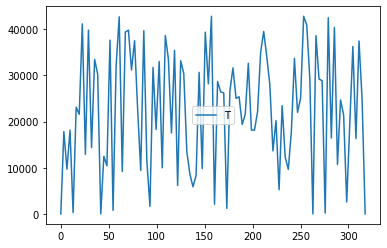

In [117]:
plt.plot(timesteps, u_sol[:,0], label="T")
plt.legend()
print(x_sol[N-1, 6])

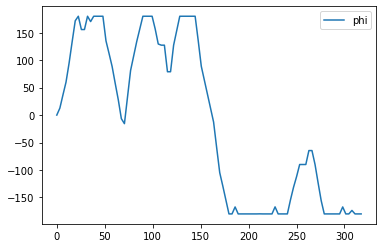

In [118]:
plt.plot(timesteps, x_sol[:,8]*180/np.pi, label="phi")
# plt.plot(timesteps, x_sol[:,8]*180/np.pi, label="psi")
plt.legend()

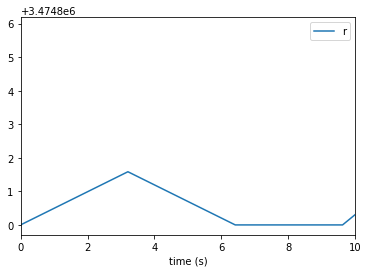

In [120]:
plt.plot(timesteps, x_sol[:,0], label='r')
# plt.plot(timesteps, u_sol[:,0], label="T")
plt.xlim(0,10)
# plt.plot(timesteps, xinit[:,0], label='guess')
plt.xlabel("time (s)")
plt.legend()

In [ ]:
# TODO: create LQR to follow the trajectory (

TypeError: ignored

In [36]:
# TODO: simulate and animate path, create disturbance in simulation
k = [1,2,3,4,5,6]
print(k[-4:-1])

[3, 4, 5]
